### Import Library

In [43]:
import os
import torch
import torchvision
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from torchvision import transforms, datasets, models
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize
from torch.utils.data import DataLoader
import timm

### Device Selection

In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### Drive Mount

In [45]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Data Preprocessing

In [46]:
# Data transforms
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),  # Ensure 3 channels
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

# Load data
train_dir = "/content/data/training"
val_dir = "/content/data/validation"

train_data = datasets.ImageFolder(train_dir, transform=transform)
val_data = datasets.ImageFolder(val_dir, transform=transform)

train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

class_names = train_data.classes
model_results = {}  # To store model name and validation accuracy

### Model Setup

In [47]:
def get_model(name, num_classes):
    if name == "resnet18":
        model = torchvision.models.resnet18(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "efficientnet_b0":
        model = torchvision.models.efficientnet_b0(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif name == "densenet121":
        model = torchvision.models.densenet121(pretrained=True)
        model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    elif name == "mobilenet_v2":
        model = torchvision.models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    elif name == "shufflenet_v2":
        model = torchvision.models.shufflenet_v2_x1_0(pretrained=True)
        model.fc = nn.Linear(model.fc.in_features, num_classes)

    elif name == "squeezenet":
        model = torchvision.models.squeezenet1_0(pretrained=True)
        model.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model.num_classes = num_classes

    else:
        raise ValueError(f"Model '{name}' not supported.")

    return model.to(device)

### Training Function

In [48]:
def train_model(model, epochs=5):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0003)

    train_loss, val_loss, train_acc, val_acc = [], [], [], []

    for epoch in range(epochs):
        model.train()
        running_loss, correct = 0, 0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_loss.append(running_loss / len(train_loader))
        train_acc.append(correct / len(train_data))

        # Validation
        model.eval()
        v_loss, v_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                v_loss += loss.item()
                v_correct += (outputs.argmax(1) == labels).sum().item()

        val_loss.append(v_loss / len(val_loader))
        val_acc.append(v_correct / len(val_data))
        print(f"Epoch {epoch+1}: Train Acc={train_acc[-1]:.2f}, Val Acc={val_acc[-1]:.2f}")

    return model, train_loss, val_loss, train_acc, val_acc

### Accuracy and Loss Graph

In [49]:
def plot_metrics(train_loss, val_loss, train_acc, val_acc):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_loss, label='Train Loss')
    plt.plot(val_loss, label='Val Loss')
    plt.legend()
    plt.title("Loss Curve")

    plt.subplot(1, 2, 2)
    plt.plot(train_acc, label='Train Acc')
    plt.plot(val_acc, label='Val Acc')
    plt.legend()
    plt.title("Accuracy Curve")
    plt.show()

### Confusion Matrix and Report

In [50]:
def evaluate_model(model):
    y_true, y_pred = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            y_true.extend(labels.cpu())
            y_pred.extend(preds.cpu())

    print(classification_report(y_true, y_pred, target_names=class_names))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

### Roc Curve

In [51]:
def plot_roc(model):
    y_score, y_true = [], []
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            outputs = model(images)
            y_score.extend(outputs.cpu())
            y_true.extend(labels)

    y_true = label_binarize(y_true, classes=list(range(len(class_names))))
    y_score = torch.stack(y_score).numpy()

    plt.figure()
    for i in range(len(class_names)):
        fpr, tpr, _ = roc_curve(y_true[:, i], y_score[:, i])
        plt.plot(fpr, tpr, label=f"{class_names[i]} (AUC = {auc(fpr, tpr):.2f})")

    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.grid(True)
    plt.show()

### Restnet 18

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.71, Val Acc=0.73
Epoch 2: Train Acc=0.86, Val Acc=0.83
Epoch 3: Train Acc=0.90, Val Acc=0.83
Epoch 4: Train Acc=0.92, Val Acc=0.78
Epoch 5: Train Acc=0.96, Val Acc=0.79
Epoch 6: Train Acc=0.97, Val Acc=0.82
Epoch 7: Train Acc=0.98, Val Acc=0.84
Epoch 8: Train Acc=0.98, Val Acc=0.84
Epoch 9: Train Acc=0.96, Val Acc=0.81
Epoch 10: Train Acc=0.97, Val Acc=0.84


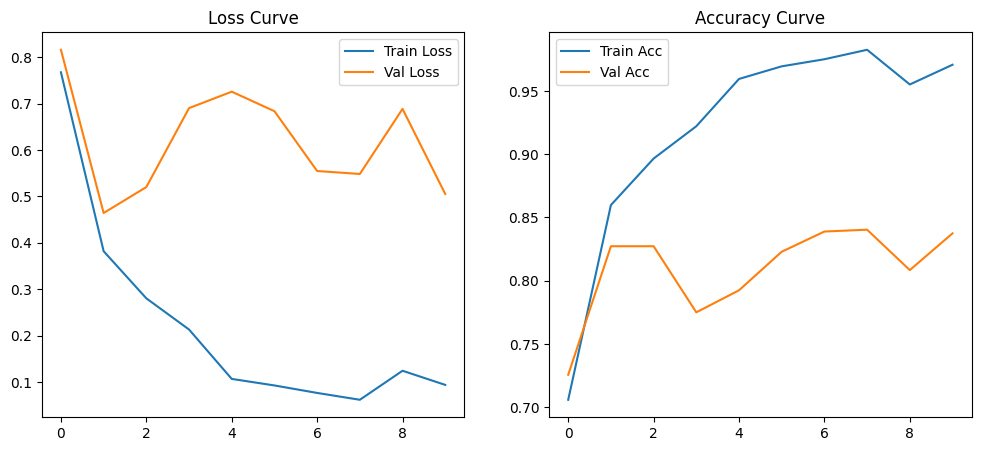

              precision    recall  f1-score   support

         abn       0.87      0.87      0.87       247
         bmt       0.66      0.56      0.61        59
        malg       0.66      0.67      0.66        81
         nml       0.90      0.96      0.93       130
         stn       0.88      0.87      0.87       172

    accuracy                           0.84       689
   macro avg       0.79      0.79      0.79       689
weighted avg       0.83      0.84      0.84       689



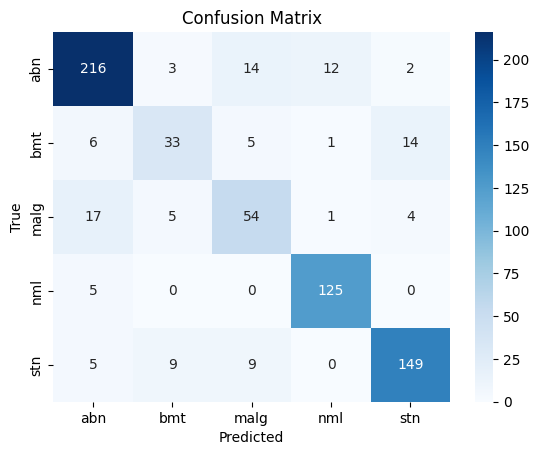

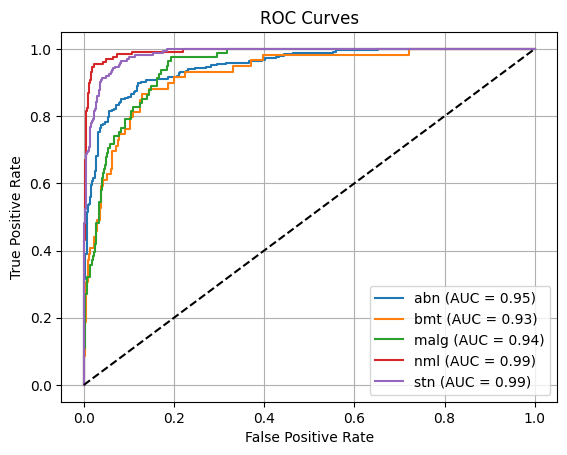

In [52]:
model = get_model("resnet18", num_classes=len(class_names))  # or "efficientnet_b0", "densenet121"
model, train_loss, val_loss, train_acc, val_acc = train_model(model, epochs=10)

plot_metrics(train_loss, val_loss, train_acc, val_acc)
evaluate_model(model)
plot_roc(model)

model_results["ResNet18"] = max(val_acc)

### Efficientnet_B0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.67, Val Acc=0.78
Epoch 2: Train Acc=0.83, Val Acc=0.82
Epoch 3: Train Acc=0.90, Val Acc=0.83
Epoch 4: Train Acc=0.91, Val Acc=0.82
Epoch 5: Train Acc=0.93, Val Acc=0.80
Epoch 6: Train Acc=0.96, Val Acc=0.85
Epoch 7: Train Acc=0.96, Val Acc=0.84
Epoch 8: Train Acc=0.98, Val Acc=0.84
Epoch 9: Train Acc=0.99, Val Acc=0.81
Epoch 10: Train Acc=0.97, Val Acc=0.84


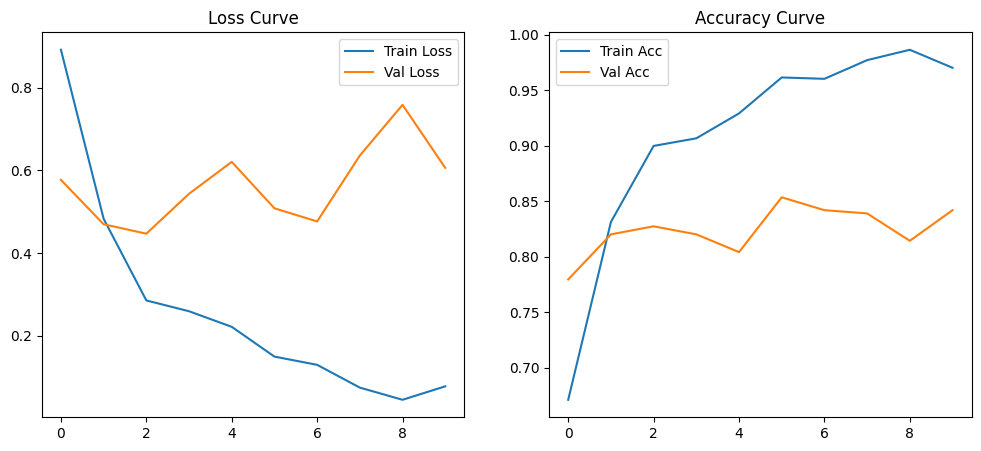

              precision    recall  f1-score   support

         abn       0.88      0.86      0.87       247
         bmt       0.69      0.49      0.57        59
        malg       0.64      0.67      0.65        81
         nml       0.86      0.97      0.91       130
         stn       0.91      0.92      0.91       172

    accuracy                           0.84       689
   macro avg       0.80      0.78      0.78       689
weighted avg       0.84      0.84      0.84       689



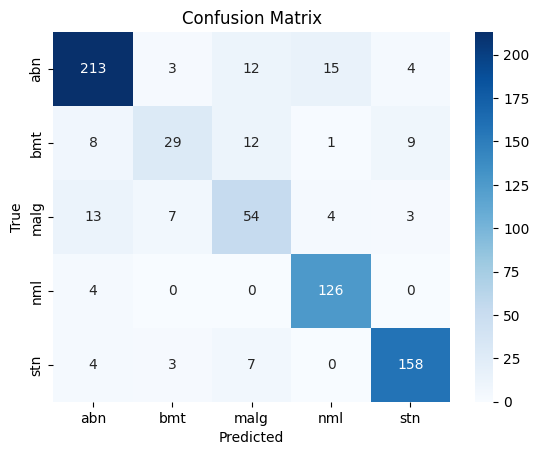

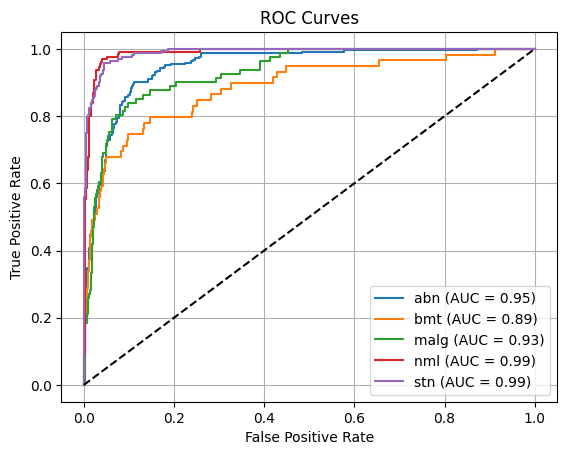

In [56]:
model = get_model("efficientnet_b0", num_classes=len(class_names))

model, train_loss, val_loss, train_acc, val_acc = train_model(model, epochs=10)

plot_metrics(train_loss, val_loss, train_acc, val_acc)
evaluate_model(model)
plot_roc(model)

model_results["EfficientNetB0"] = max(val_acc)

### Densenet-121

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.70, Val Acc=0.77
Epoch 2: Train Acc=0.84, Val Acc=0.82
Epoch 3: Train Acc=0.88, Val Acc=0.80
Epoch 4: Train Acc=0.90, Val Acc=0.84
Epoch 5: Train Acc=0.92, Val Acc=0.81
Epoch 6: Train Acc=0.96, Val Acc=0.83
Epoch 7: Train Acc=0.97, Val Acc=0.84
Epoch 8: Train Acc=0.98, Val Acc=0.84
Epoch 9: Train Acc=0.98, Val Acc=0.84
Epoch 10: Train Acc=0.98, Val Acc=0.83


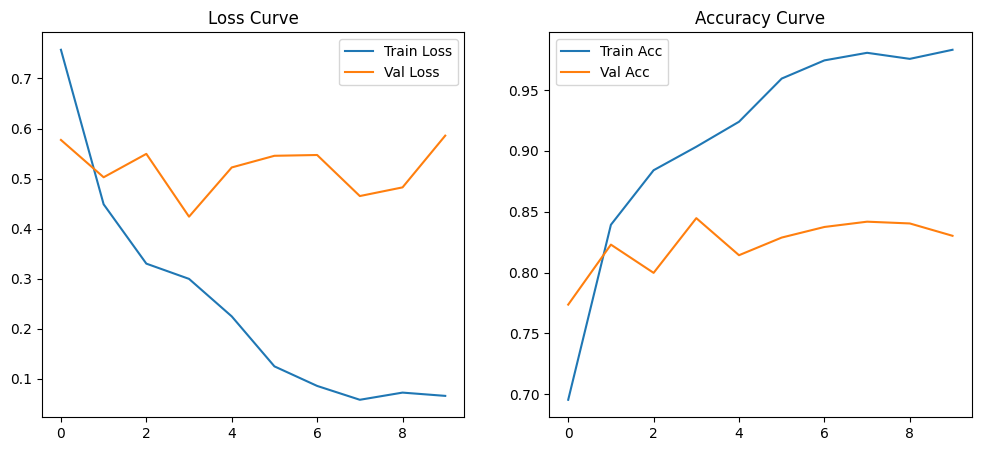

              precision    recall  f1-score   support

         abn       0.88      0.80      0.84       247
         bmt       0.69      0.58      0.63        59
        malg       0.58      0.78      0.67        81
         nml       0.89      0.95      0.92       130
         stn       0.91      0.90      0.90       172

    accuracy                           0.83       689
   macro avg       0.79      0.80      0.79       689
weighted avg       0.84      0.83      0.83       689



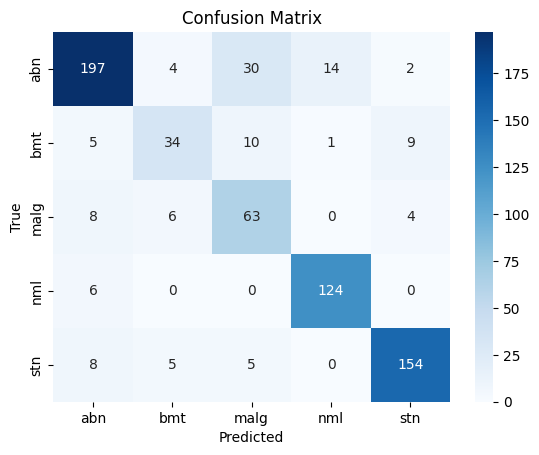

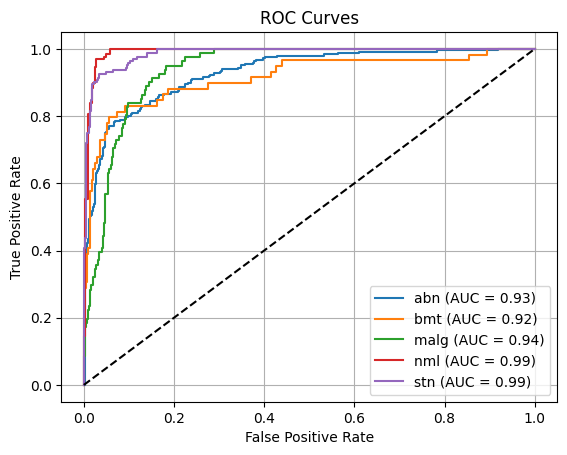

In [54]:
model = get_model("densenet121", num_classes=len(class_names))


model, train_loss, val_loss, train_acc, val_acc = train_model(model, epochs=10)

plot_metrics(train_loss, val_loss, train_acc, val_acc)
evaluate_model(model)
plot_roc(model)

model_results["DenseNet121"] = max(val_acc)

### MobileNetV2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.70, Val Acc=0.78
Epoch 2: Train Acc=0.81, Val Acc=0.78
Epoch 3: Train Acc=0.88, Val Acc=0.82
Epoch 4: Train Acc=0.88, Val Acc=0.79
Epoch 5: Train Acc=0.95, Val Acc=0.81
Epoch 6: Train Acc=0.96, Val Acc=0.83
Epoch 7: Train Acc=0.97, Val Acc=0.82
Epoch 8: Train Acc=0.97, Val Acc=0.82
Epoch 9: Train Acc=0.92, Val Acc=0.83
Epoch 10: Train Acc=0.97, Val Acc=0.85


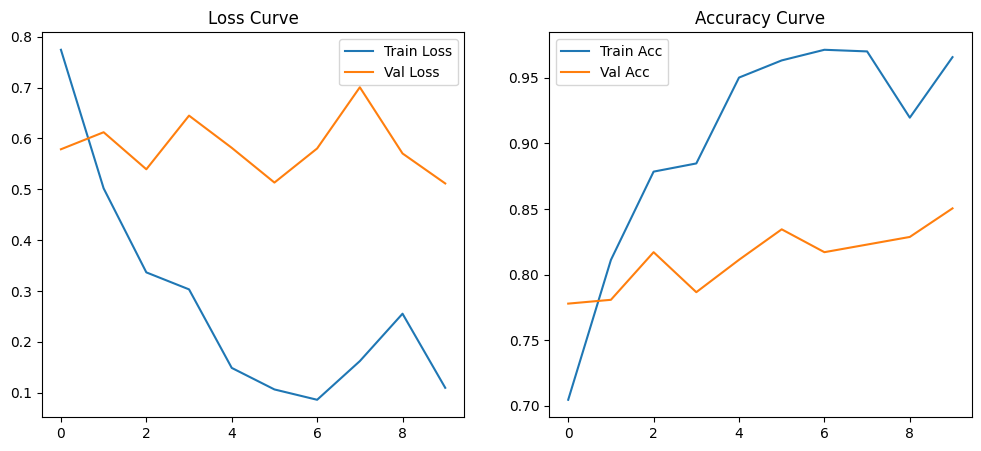

              precision    recall  f1-score   support

         abn       0.87      0.87      0.87       247
         bmt       0.69      0.68      0.68        59
        malg       0.72      0.62      0.67        81
         nml       0.87      0.97      0.92       130
         stn       0.91      0.90      0.90       172

    accuracy                           0.85       689
   macro avg       0.81      0.81      0.81       689
weighted avg       0.85      0.85      0.85       689



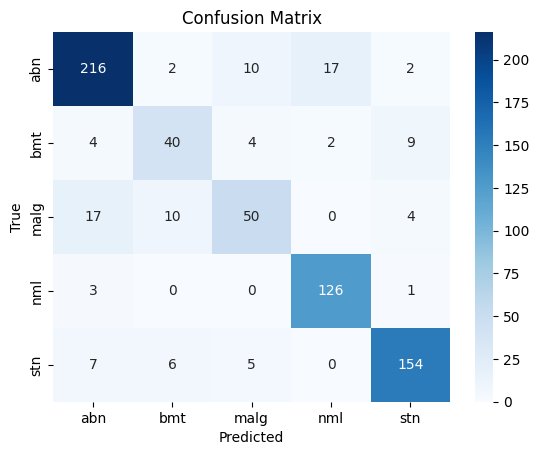

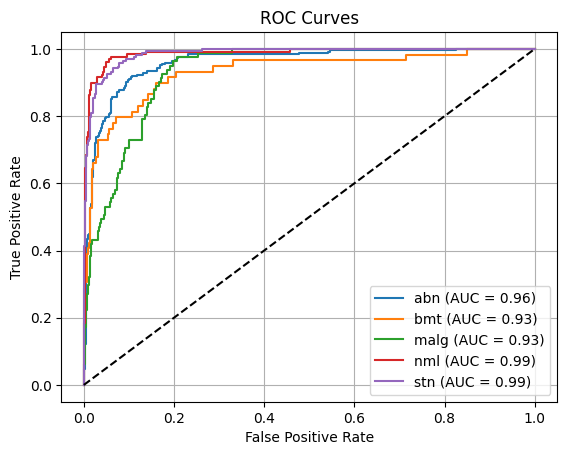

In [57]:
model = get_model("mobilenet_v2", num_classes=len(class_names))
model, train_loss, val_loss, train_acc, val_acc = train_model(model, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)
evaluate_model(model)
plot_roc(model)

model_results["MobileNetV2"] = max(val_acc)

### ShuffleNetV2

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ShuffleNet_V2_X1_0_Weights.IMAGENET1K_V1`. You can also use `weights=ShuffleNet_V2_X1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.62, Val Acc=0.70
Epoch 2: Train Acc=0.71, Val Acc=0.73
Epoch 3: Train Acc=0.75, Val Acc=0.80
Epoch 4: Train Acc=0.83, Val Acc=0.79
Epoch 5: Train Acc=0.89, Val Acc=0.82
Epoch 6: Train Acc=0.93, Val Acc=0.82
Epoch 7: Train Acc=0.94, Val Acc=0.83
Epoch 8: Train Acc=0.96, Val Acc=0.81
Epoch 9: Train Acc=0.97, Val Acc=0.83
Epoch 10: Train Acc=0.97, Val Acc=0.82


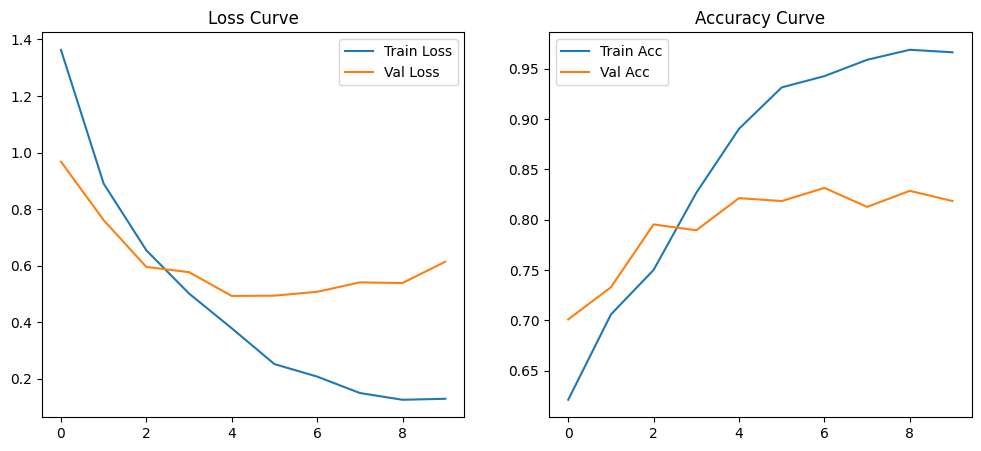

              precision    recall  f1-score   support

         abn       0.83      0.89      0.86       247
         bmt       0.57      0.56      0.56        59
        malg       0.65      0.69      0.67        81
         nml       0.90      0.86      0.88       130
         stn       0.93      0.84      0.88       172

    accuracy                           0.82       689
   macro avg       0.77      0.77      0.77       689
weighted avg       0.82      0.82      0.82       689



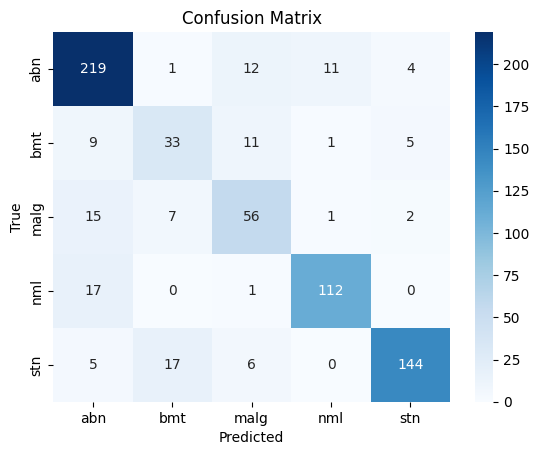

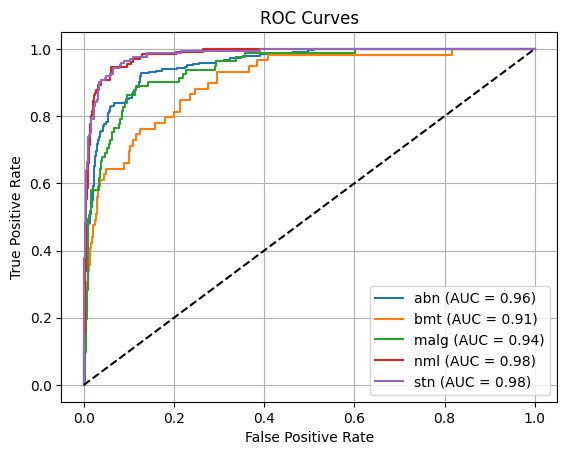

In [59]:
model = get_model("shufflenet_v2", num_classes=len(class_names))
model, train_loss, val_loss, train_acc, val_acc = train_model(model, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)
evaluate_model(model)
plot_roc(model)

model_results["ShuffleNetV2"] = max(val_acc)

### SqueezeNet1_0

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=SqueezeNet1_0_Weights.IMAGENET1K_V1`. You can also use `weights=SqueezeNet1_0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1: Train Acc=0.57, Val Acc=0.68
Epoch 2: Train Acc=0.65, Val Acc=0.73
Epoch 3: Train Acc=0.73, Val Acc=0.72
Epoch 4: Train Acc=0.73, Val Acc=0.76
Epoch 5: Train Acc=0.78, Val Acc=0.76
Epoch 6: Train Acc=0.78, Val Acc=0.74
Epoch 7: Train Acc=0.77, Val Acc=0.79
Epoch 8: Train Acc=0.80, Val Acc=0.81
Epoch 9: Train Acc=0.82, Val Acc=0.81
Epoch 10: Train Acc=0.81, Val Acc=0.78


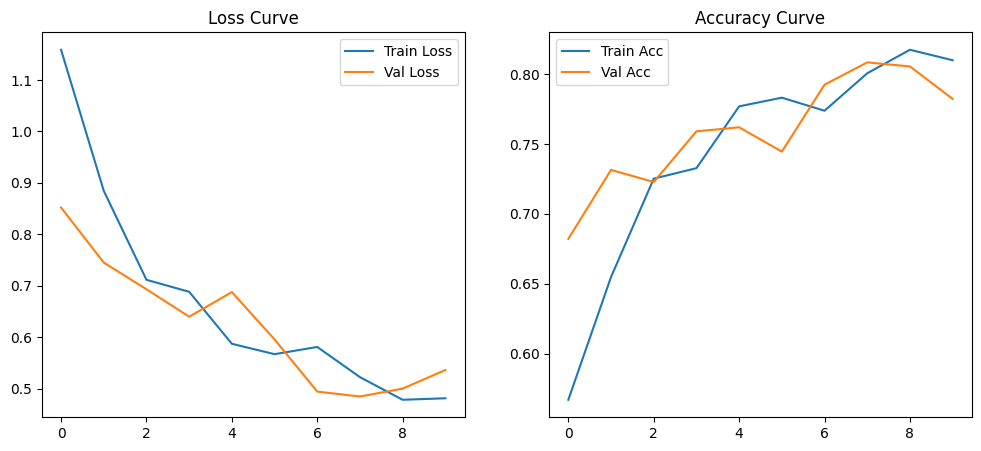

              precision    recall  f1-score   support

         abn       0.73      0.96      0.83       247
         bmt       0.50      0.61      0.55        59
        malg       0.76      0.32      0.45        81
         nml       0.95      0.80      0.87       130
         stn       0.92      0.78      0.85       172

    accuracy                           0.78       689
   macro avg       0.77      0.70      0.71       689
weighted avg       0.80      0.78      0.77       689



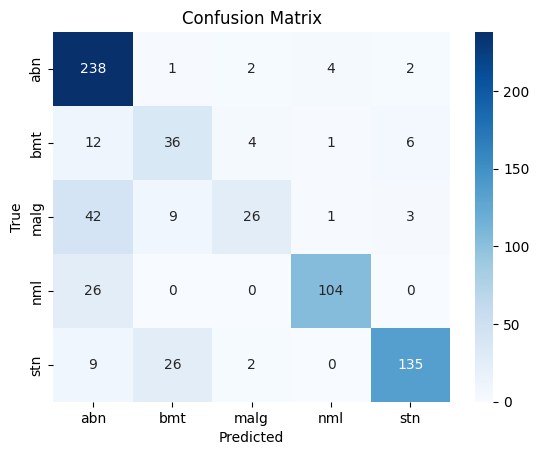

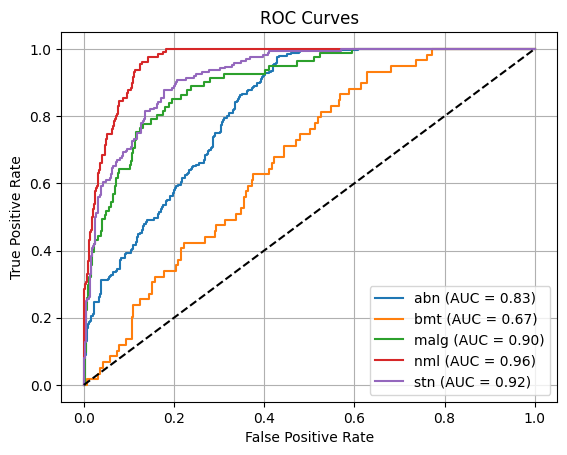

In [60]:
model = get_model("squeezenet", num_classes=len(class_names))
model, train_loss, val_loss, train_acc, val_acc = train_model(model, epochs=10)
plot_metrics(train_loss, val_loss, train_acc, val_acc)
evaluate_model(model)
plot_roc(model)

model_results["squeezeNet"] = max(val_acc)

### Table

In [61]:
# Convert dictionary to DataFrame and format accuracy as percentage
results_df = pd.DataFrame(list(model_results.items()), columns=["Model", "Validation Accuracy"])
results_df["Validation Accuracy"] = results_df["Validation Accuracy"].apply(lambda x: f"{x*100:.2f}%")

# Display the table
print("\nModel Performance Summary:")
print(results_df.to_string(index=False))


Model Performance Summary:
         Model Validation Accuracy
      ResNet18              84.03%
EfficientNetB0              85.34%
   DenseNet121              84.47%
   MobileNetV2              85.05%
  ShuffleNetV2              83.16%
    squeezeNet              80.84%
